<a href="https://colab.research.google.com/github/deepakgarg08/llm-diary/blob/main/llm_chronicles_using_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Building decoder-based LLMs from scratch

If you want to build an LLM from scratch, check these two resources:

- https://www.youtube.com/watch?v=kCc8FmEb1nY
- https://www.manning.com/books/build-a-large-language-model-from-scratch

# 2 - Install dependencies

We only need the following libraries to experiment with running LLMs locally (or in a notebook):


*   Hugging Face Transformers
*   Accelerate (for device_map)
*   Bitsandbytes (for 4-bit quantization)



In [ ]:
!pip install transformers accelerate bitsandbytes

from transformers import AutoTokenizer, AutoModelForCausalLM

access_token = "" # Replace with your token

# 3 - Determine hardware requirements to run an LLM

To determine the hardware requirements for running a Large Language Model (LLM), it's essential to understand the memory allocation for both inference and training phases. Below are key details regarding the GPU RAM needs:

- **Parameter Size**: Each parameter in the model is represented as a 32-bit floating-point value, which requires 4 bytes of memory.
- **Inference Memory**: For inference purposes, a 1 billion parameter LLM will need approximately 4 GB of GPU RAM to be loaded.
- **Training Memory**: Training and fine-tuning the model significantly increase memory requirements. The total memory needed is about 24 GB per billion parameters, which is around 6 times the amount required for inference. This expansion accommodates gradients, optimizer parameters, activations, and temporary memory essential during the training process.

Hugging Face Memory Requirement Calculator: https://huggingface.co/spaces/hf-accelerate/model-memory-usage

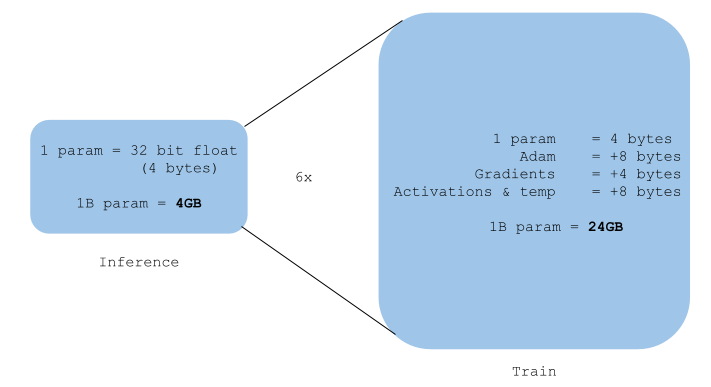

In [ ]:
!nvidia-smi

Sun Apr 14 15:58:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              29W /  70W |   4321MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 4 - Using Google Gemma's base model

To run the following code, you must have got access to Gemma's weights and have an access token from Hugging Face. You can find instructions on the model cards on the hugging face hub: https://huggingface.co/google/gemma-2b.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b",use_auth_token=access_token)
model = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto",use_auth_token=access_token)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:466: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [ ]:
# Next-word prediction
input_text = "Back to the Tiramisu Land is a 2080 Italian science fiction film directed by Donato and"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(
    input_ids,
    max_length=100,
    temperature=1.0,  # Higher values make output more random; default is 1
    top_k=0,          # Limits the model to the top k probabilities; use 0 to disable
    top_p=0.9         # Nucleus sampling: only consider the top p probability mass; use 1.0 to disable
)

print(tokenizer.decode(outputs[0]))

<bos>Back to the Tiramisu Land is a 2080 Italian science fiction film directed by Donato and directed by Donato Carrisi. The film is a sequel to the 2013 film Back to the Tiramisu. The film was released on 2019.

<h2>Back to the Tiramisu Land (2019)</h2>

The film is a sequel to the 2013 film Back to the Tiramisu. The film is a sequel to the


In [ ]:
# Emergent abilities
input_text = "English: hello, Italian:ciao\nEnglish:i love you, Italian:"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

# Adding temperature, top_k, and top_p parameters to control the generation
outputs = model.generate(
    input_ids,
    max_length=50,
    temperature=0.5,  # Higher values make output more random; default is 1
    top_k=0,          # Limits the model to the top k probabilities; use 0 to disable
    top_p=0.9         # Nucleus sampling: only consider the top p probability mass; use 1.0 to disable
)

print(tokenizer.decode(outputs[0]))

<bos>English: hello, Italian:ciao
English:i love you, Italian:ti amo
English:i miss you, Italian:mi manco
English:i'm sorry, Italian:mi scusi
English:i'm


# 5 - Llama-2 7B with 4-bit quantization  

In this notebook, we use 4-bit quantization to run Llama-7B Chat model. This code uses only 10 GB of VRAM. It can run on a free instance of Google Colab or on a local GPU (e.g., RTX 3060 12GB): https://open.substack.com/pub/kaitchup/p/run-llama-2-chat-models-on-your-computer?r=2kp66c&utm_campaign=post&utm_medium=web

**Quantization** is a technique used to reduce the precision of the numbers used in a model to accelerate inference, decrease model size, and sometimes even improve model robustness. By representing model parameters with lower precision, quantization can significantly cut down on the computational resources needed, particularly memory and processing power.



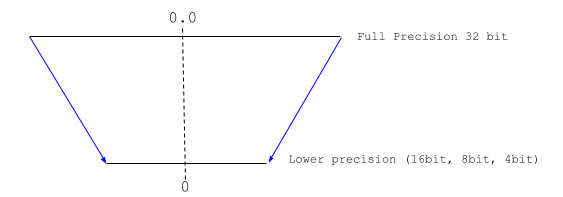

## Types of Quantization

- **FP16 (Half Precision)**:
 - FP16 reduces the standard 32-bit floating point (FP32) to 16 bits. This can halve the model size and generally speed up the processing on hardware that supports FP16 operations efficiently.
 - Use Case: Often used in GPUs for training and inference to achieve a balance between performance and precision.
- **INT8**:
 - INT8 quantization converts floating-point values into 8-bit integers. This type of quantization can greatly reduce the computational demand and memory usage.
 - Use Case: Widely used for inference in edge devices and mobile platforms where computational resources are limited.
- **INT4**:
 - INT4 involves reducing data to just 4 bits per parameter, which offers significant memory savings and efficiency but at the potential cost of accuracy.
 - Use Case: Suitable for highly resource-constrained environments but requires careful implementation to manage the loss in precision.


In [ ]:
# Load llama 2 7B
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", device_map="auto", load_in_4bit=True,  use_auth_token=access_token)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_fast=True, use_auth_token=access_token)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:466: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
input_text = "English: hello, Italian:ciao\nEnglish: glass, Italian:"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_length = 50)
print(tokenizer.decode(outputs[0]))

<s> English: hello, Italian:ciao
English: glass, Italian: vetro
English: glass, Italian: vetro
English: glass, Italian: vetro, Spanish: vidrio
English: glass, Italian: vetro


# 6 - Gemma - Instruction fine-tuned version

Instruction fine-tuning is a process that refines a large language model's ability to follow specific instructions more accurately. It involves training the model on a dataset of examples where each input is paired with a desired output, according to particular instructions. This specialized training helps the model improve at understanding and executing complex commands in a way that aligns more closely with human expectations.`

Example fine-tuning dataset: https://huggingface.co/datasets/WizardLM/WizardLM_evol_instruct_V2_196k


https://huggingface.co/google/gemma-1.1-2b-it

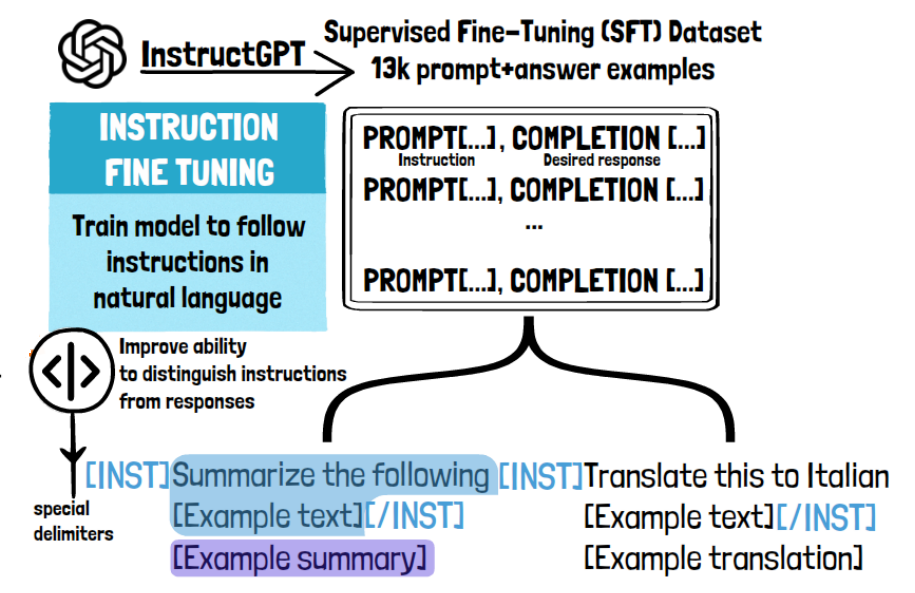

In [ ]:
model_name = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name,use_auth_token=access_token)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto",use_auth_token=access_token)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:466: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
input_text = "<start_of_turn>user\nWrite a Python script that prints 'I love you'"
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_length = 100)
print(tokenizer.decode(outputs[0]))

<bos>Write a Python script that prints 'I love you' to the user.

```python
print("I love you")
```

**Explanation:**

* The script starts with the `print()` function, which takes one or more arguments and prints them on the terminal.
* In this case, we are printing the string "I love you".
* The `print()` function is a built-in function in Python, and it is commonly used to display messages or output data


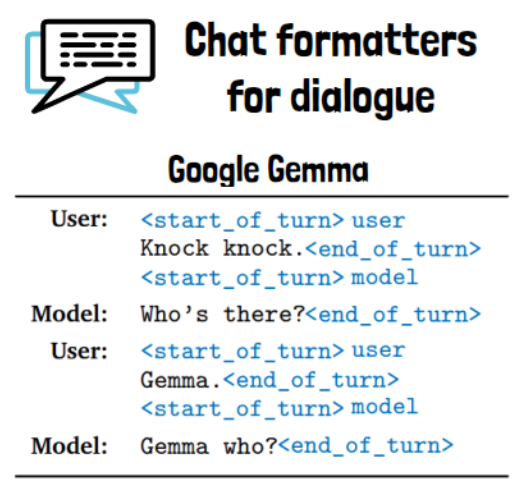

In [ ]:
# We could include the chat formatters manually, but Hugging Face Tokenizer
# also implments convenient templates for the different models.
chat = [
    { "role": "user", "content": "Explain how a neural network works in a few sentences." },
    { "role": "model", "content": "A neural network is a computational model inspired by the structure and function of the human brain." },
    { "role": "user", "content": "In which way is it inspired by the human brain?." },
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
prompt

'<bos><start_of_turn>user\nExplain how a neural network works in a few sentences.<end_of_turn>\n<start_of_turn>model\nA neural network is a computational model inspired by the structure and function of the human brain.<end_of_turn>\n<start_of_turn>user\nIn which way is it inspired by the human brain?.<end_of_turn>\n<start_of_turn>model\n'

In [ ]:
inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=50)
print(tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
Explain how a neural network works in a few sentences.<end_of_turn>
<start_of_turn>model
A neural network is a computational model inspired by the structure and function of the human brain.<end_of_turn>
<start_of_turn>user
In which way is it inspired by the human brain?.<end_of_turn>
<start_of_turn>model
Neural networks are inspired by the structure and function of the human brain, particularly in their hierarchical organization and the interconnectedness of its neurons.<eos>


# 7 - Llama-2-chat

https://huggingface.co/meta-llama/Llama-2-7b-chat-hf

In [ ]:
# Load Llama 2 7B Chat
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf", device_map="auto", load_in_4bit=True,  use_auth_token=access_token)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", use_fast=True, use_auth_token=access_token)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:466: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:720: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
input_text = "[INST] Write a program in python to sort a list of names. [/INST] "
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = model.generate(**input_ids, max_length = 100)
print(tokenizer.decode(outputs[0]))

<s> Write a program in python to sort a list of names.ℓ

Here is a list of names:

['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Frank']

Write a program in Python to sort this list of names in alphabetical order.

Hint: You can use the built-in `sorted()` function in Python to sort a list.</s>
